In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import graph_tool.all as gt
import networkx as nx
from imdb import IMDb
import json
import pickle

# GoT co-star network

 - nodes: actors/characters of GoT
 - edges: movies

# Previously

```python
edgelist = thrones.groupby('imdb_id')['id'].apply(
    lambda x: tuple(sorted(combinations(x, 2)))).explode()

edgelist.to_csv('../data/edgelist_got.csv', index=False)
thrones.to_csv('../data/got.csv', index=False)
```

In [2]:
import pandas as pd

In [3]:
edgelist = pd.read_csv(
    '../data/edgelist_got.csv')
edgelist.head()

,id
0,"('nm0574534', 'nm0822062')"
1,"('nm0234541', 'nm0891092')"
2,"('nm0002103', 'nm0891092')"
3,"('nm0574534', 'nm0181920')"
4,"('nm0822062', 'nm0838910')"


In [4]:
thrones = pd.read_csv('../data/got.csv')
thrones.head()

,imdb_id,title,year,id,name,character
0,tt4699982,Rebellion,2016.0,nm0269923,Michael Feast,Aeron Greyjoy
1,tt4699982,Rebellion,2016.0,nm0568400,Ian McElhinney,Barristan Selmy
2,tt4699982,Rebellion,2016.0,nm0265610,Michelle Fairley,Catelyn Stark
3,tt4699982,Rebellion,2016.0,nm0734498,Lalor Roddy,Catspaw Assassin
4,tt4699982,Rebellion,2016.0,nm5697839,Jed Murray,Northman Rioter


In [5]:
print(type(edgelist['id'].iloc[0]))
print(type(eval(edgelist['id'].iloc[0])))

<class 'str'>
<class 'tuple'>


In [6]:
edgelist['id'] = edgelist['id'].apply(
    eval)
print(type(edgelist['id'].iloc[0]))

<class 'tuple'>


In [7]:
def get_tuple_item(x, which='smaller'):
    order = sorted(x)
    if which == 'smaller':
        return order[0]
    else:
        return order[1]

In [8]:
# Make an adjacency DataFrame
adj_df = pd.DataFrame()

adj_df['source'] = edgelist['id'].apply(
    get_tuple_item)
adj_df['target'] = edgelist['id'].apply(
    get_tuple_item, which='greater')

In [9]:
adj_df.head()

,source,target
0,nm0574534,nm0822062
1,nm0234541,nm0891092
2,nm0002103,nm0891092
3,nm0181920,nm0574534
4,nm0822062,nm0838910


In [10]:
adj_df = adj_df.groupby(['source', 'target']).size().rename('weight').reset_index()
adj_df.head()

,source,target,weight
0,nm0000293,nm0000596,2
1,nm0000293,nm0000980,1
2,nm0000293,nm0001097,2
3,nm0000293,nm0001290,1
4,nm0000293,nm0002103,1


## NetworkX

Format files to read a network:

 1. Adjacency List: `u, v_1, v_2, v_3`
 2. Edgelist: `u, v_1, w_1, w_2`
 3. GEXF
 4. GML
 5. GraphML
 6. GIS Shapefile

```python
Signature:
nx.from_pandas_edgelist(
    df,
    source='source',
    target='target',
    edge_attr=None,
    create_using=None,
    edge_key=None,
)
```

In [11]:
G = nx.from_pandas_edgelist(
    adj_df,
    edge_attr='weight')

In [12]:
print("Number of nodes", len(G))
print("Number of edges", len(G.edges))

Number of nodes 304
Number of edges 2255


In [13]:
print("Número de CC",
      nx.number_connected_components(G))
print("Tamaño en nodos",
      [len(cc) for cc in nx.connected_components(G)])

Número de CC 2
Tamaño en nodos [302, 2]


In [14]:
nodes = next(nx.connected_components(G))
H = G.subgraph(nodes)

In [15]:
print("nodes", len(H))
print("edges", len(H.edges))

nodes 302
edges 2254


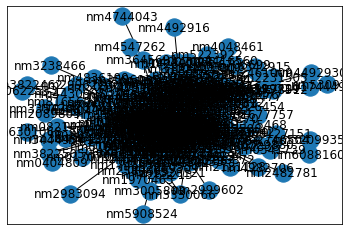

In [16]:
nx.draw_networkx(H)

# Degree distribution

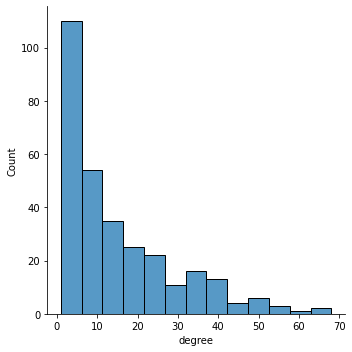

In [17]:
degree = pd.DataFrame(H.degree, columns=['id', 'degree']).sort_values('degree', ascending=False)
sns.displot(degree['degree'])

In [18]:
thrones.head()

,imdb_id,title,year,id,name,character
0,tt4699982,Rebellion,2016.0,nm0269923,Michael Feast,Aeron Greyjoy
1,tt4699982,Rebellion,2016.0,nm0568400,Ian McElhinney,Barristan Selmy
2,tt4699982,Rebellion,2016.0,nm0265610,Michelle Fairley,Catelyn Stark
3,tt4699982,Rebellion,2016.0,nm0734498,Lalor Roddy,Catspaw Assassin
4,tt4699982,Rebellion,2016.0,nm5697839,Jed Murray,Northman Rioter


In [19]:
actors = thrones.groupby(['id', 'character'])[['imdb_id']].size().rename(
    'number_movies').reset_index()
actors.head()

,id,character,number_movies
0,nm0000293,Eddard Stark,90
1,nm0000596,High Sparrow,91
2,nm0000980,Archmaester Marwyn,120
3,nm0001097,Tywin Lannister,105
4,nm0001216,Selyse Baratheon,41


In [20]:
# Merge DataFrames `degree` and `thrones`
degree = pd.merge(degree, actors, how='left', on="id")
degree.head(10)

,id,degree,character,number_movies
0,nm0000980,68,Archmaester Marwyn,120
1,nm0001097,63,Tywin Lannister,105
2,nm0568400,62,Barristan Selmy,76
3,nm0181920,57,Jeor Mormont,106
4,nm0700059,53,Craster,78
5,nm0504320,53,Qyburn,73
6,nm0538869,52,Balon Greyjoy,61
7,nm0408591,51,Dagmer Cleftjaw,54
8,nm0838910,51,Maester Luwin,59
9,nm0103195,51,Walder Frey,68


In [21]:
degree['ratio_deg_nmovies'] = degree['degree'] / degree['number_movies']
degree.sort_values('ratio_deg_nmovies').tail(10)

,id,degree,character,number_movies,ratio_deg_nmovies
132,nm4789912,12,Ornela,5,2.400000
206,nm3122423,5,Knight of House Frey,2,2.500000
120,nm1638006,13,Bowen Marsh,5,2.600000
74,nm4335246,22,Stark Guard,8,2.750000
249,nm5223922,3,Selyse Baratheon,1,3.000000
153,nm5390029,10,Warlock,3,3.333333
234,nm4385245,4,Timett,1,4.000000
222,nm4475335,5,Jaremy Rykker,1,5.000000
223,nm5981376,5,Stark Guard,1,5.000000
80,nm5081192,21,Shireen Baratheon,4,5.250000


# Game of Thrones

Graph $H$

Nodes: Actors

Edges: Movies

Is there a segregation based on any factor between the actors?

In [22]:
degree.head()

,id,degree,character,number_movies,ratio_deg_nmovies
0,nm0000980,68,Archmaester Marwyn,120,0.566667
1,nm0001097,63,Tywin Lannister,105,0.600000
2,nm0568400,62,Barristan Selmy,76,0.815789
3,nm0181920,57,Jeor Mormont,106,0.537736
4,nm0700059,53,Craster,78,0.679487


In [23]:
add = pd.read_csv('../data/got_add.csv')
add.head()

,DoB,PoB,height,id,country,age
0,1959-04-17,"Sheffield, South Yorkshire, England, UK",1.79,nm0000293,England,61.0
1,1947-06-01,"Holywell, Flintshire, Wales, UK",1.83,nm0000596,Wales,73.0
2,1949-05-24,"Lincoln, Lincolnshire, England, UK",1.88,nm0000980,England,71.0
3,1946-10-10,"Redditch, Worcestershire, England, UK",1.91,nm0001097,England,74.0
4,1967-09-18,"Cuckfield, Sussex, England, UK",1.65,nm0001216,England,53.0


In [31]:
nodes = pd.merge(degree, add, how='left')
nodes.head()

,id,degree,character,number_movies,ratio_deg_nmovies,DoB,PoB,height,country,age
0,nm0000980,68,Archmaester Marwyn,120,0.566667,1949-05-24,"Lincoln, Lincolnshire, England, UK",1.88,England,71.0
1,nm0001097,63,Tywin Lannister,105,0.600000,1946-10-10,"Redditch, Worcestershire, England, UK",1.91,England,74.0
2,nm0568400,62,Barristan Selmy,76,0.815789,1948-08-19,"Belfast, Northern Ireland, UK",1.81,Northern Ireland,72.0
3,nm0181920,57,Jeor Mormont,106,0.537736,1948-05-24,"Clydebank, Dunbartonshire, Scotland, UK",1.88,Scotland,72.0
4,nm0700059,53,Craster,78,0.679487,1950-00-00,"Aberdare, Glamorgan, Wales, UK",NaN,Wales,71.0


In [32]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 301
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 302 non-null    object 
 1   degree             302 non-null    int64  
 2   character          302 non-null    object 
 3   number_movies      302 non-null    int64  
 4   ratio_deg_nmovies  302 non-null    float64
 5   DoB                173 non-null    object 
 6   PoB                171 non-null    object 
 7   height             233 non-null    float64
 8   country            171 non-null    object 
 9   age                173 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 26.0+ KB


In [33]:
nodes = nodes.dropna()

In [35]:
I = H.subgraph(nodes['id'])

# Assortativity

 Preference for a network's nodes to attach to others that are similar in some way.
 
  - A value close to 1: low mixing.
  - A value close to -1: high mixing.
  - A value close to 0: random mixing.

```
Signature: nx.numeric_assortativity_coefficient(G, attribute, nodes=None)
Docstring:
Compute assortativity for numerical node attributes.

Assortativity measures the similarity of connections
in the graph with respect to the given numeric attribute.
The numeric attribute must be an integer.
```

In [44]:
# Change columns from float to int
nodes['height'] = (nodes['height'] * 100).astype(int)
nodes['age'] = nodes['age'].astype(int)

```
Signature: nx.attribute_assortativity_coefficient(G, attribute, nodes=None)
Docstring:
Compute assortativity for node attributes.

Assortativity measures the similarity of connections
in the graph with respect to the given attribute.
```

```
Signature: nx.set_node_attributes(G, values, name=None)
Docstring:
Sets node attributes from a given value or dictionary of values.
```

In [48]:
list(zip([1, 2, 3], ['a', 'b'], [8.]))

[(1, 'a', 8.0)]

In [52]:
att_country = dict(zip(nodes['id'], nodes['country']))
att_height = dict(zip(nodes['id'], nodes['height']))
att_age = dict(zip(nodes['id'], nodes['age']))

In [53]:
nx.set_node_attributes(I, att_country, 'country')
nx.set_node_attributes(I, att_height, 'height')
nx.set_node_attributes(I, att_age, 'age')

In [55]:
nx.numeric_assortativity_coefficient(I, 'height')

0.023530013263512405

In [56]:
nx.attribute_assortativity_coefficient(I, 'country')

0.08915080693563078

In [57]:
nx.numeric_assortativity_coefficient(I, 'age')

0.15824926388401794